# Analyzing Amazon.com 130+ million customer review data using SageMaker and Athena

1. [Introduction](#Introduction)
2. [Topic-based unsupervised review grouping](#Topic-based unsupervised review grouping)
  1. [Permissions and environment variables](#Permissions-and-environment-variables)
  2. [Data ingestion](#Data-ingestion)
  3. [Data inspection](#Data-inspection)
  4. [Data conversion](#Data-conversion)
3. [Training the K-Means model](#Training-the-K-Means-model)
4. [Set up hosting for the model](#Set-up-hosting-for-the-model)
5. [Validate the model for use](#Validate-the-model-for-use)

# Introduction

This notebook is a 2 part hands-on demonstration of working with Amazon review data for text analytics using [Amazon SageMaker](https://aws.amazon.com/sagemaker/). The first part uses [LDA](https://docs.aws.amazon.com/sagemaker/latest/dg/lda.html) and [K-Means](https://docs.aws.amazon.com/sagemaker/latest/dg/k-means.html) algorithms to automatically group together reviews based on topics discussed within the text. The second part covers predicting review scores using [Linear Learner](https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner.html) and [Factorization Machine](https://docs.aws.amazon.com/sagemaker/latest/dg/fact-machines.html) based on contents of the review. The end shows how to predict the rating of a new review based on the models.

In [95]:
# Define IAM role
import os
import boto3
import time
import re
from sagemaker import get_execution_role

role = get_execution_role()
# role = 'arn:aws:iam::082256166551:role/service-role/AmazonSageMaker-ExecutionRole-20171208T110841'
bucket = 'pilho-lab-us-east-1'
prefix = 'amazonreview/kmeans'

### Data ingestion

For small datasets, such as this one, reading into memory isn't onerous, though it would be for larger datasets. We will use Amazon.com review open data available at https://s3.amazonaws.com/amazon-reviews-pds/readme.html More classified data is available at http://jmcauley.ucsd.edu/data/amazon/

Let's first see what are included in `amazon-reviews-pdf` s3 bucket.

In [96]:
s3 = boto3.resource('s3')
#bucket = s3.Bucket('aws-athena-query-results-082256166551-us-east-1/Unsaved/2018/06/11')
#sourceBucket = s3.Bucket('aws-athena-query-results-082256166551-us-east-1')
#sourceBucket = s3.Bucket('amazon-reviews-pds/parquet/product_category=Books/')
sourceBucket = s3.Bucket('amazon-reviews-pds')

for obj in sourceBucket.objects.all():
    print(obj.key)

LICENSE.txt
license.txt
parquet/product_category=Apparel/part-00000-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet
parquet/product_category=Apparel/part-00001-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet
parquet/product_category=Apparel/part-00002-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet
parquet/product_category=Apparel/part-00003-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet
parquet/product_category=Apparel/part-00004-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet
parquet/product_category=Apparel/part-00005-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet
parquet/product_category=Apparel/part-00006-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet
parquet/product_category=Apparel/part-00007-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet
parquet/product_category=Apparel/part-00008-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet
parquet/product_category=Apparel/part-00009-495c48e6-96d6-4650-aa65

The above results shows how billions of review data are stored as an object in S3. Let's import them into Athena and perform SQL queries to get more details. Follow the instruction at https://s3.amazonaws.com/amazon-reviews-pds/readme.html. This lab does not handle this importing part. 

After finishing importing, you can perform a SQL query. The below screenshot shows one example. For your information, Athena's query results are automatically saved back to S3. Let's utilize one of the result. Note to set the property of a target CSV as a public readable.

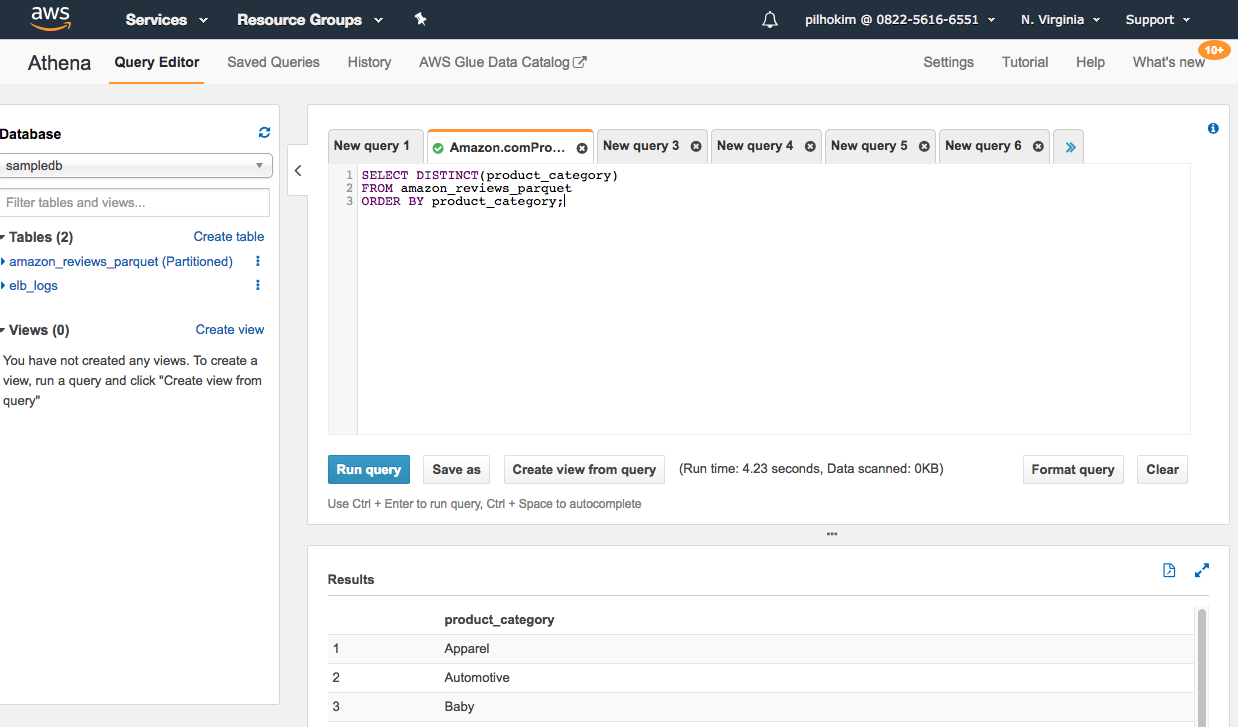

Athena SQL query

```sql
SELECT DISTINCT(product_category)
FROM amazon_reviews_parquet
ORDER BY product_category;
```

In [97]:
%%time
import numpy as np
import pickle, csv, numpy, urllib.request, json
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook

# Load the dataset from https://archive.ics.uci.edu/ml/datasets/Wholesale+customers
# This data is found at http://www.learnbymarketing.com/tutorials/k-means-clustering-in-r-example/ 
# Let's first play with a single sample CSV file
sourceCSV = 's3://aws-athena-query-results-082256166551-us-east-1/Unsaved/2018/06/25/724750a6-f431-4505-b7ff-85ae621ef561.csv'
source_data = pd.read_csv(sourceCSV, header = 'infer')

display(source_data)


,product_category
0,Apparel
1,Automotive
2,Baby
3,Beauty
4,Books
5,Camera
6,Digital_Ebook_Purchase
7,Digital_Music_Purchase
8,Digital_Software
9,Digital_Video_Download


CPU times: user 56 ms, sys: 20 ms, total: 76 ms
Wall time: 120 ms


Let's select a sample data for training using Athena.

```sql
SELECT *
FROM amazon_reviews_parquet
WHERE product_category = 'Books'
LIMIT 10000
```

In [98]:
sourceCSV = 's3://aws-athena-query-results-082256166551-us-east-1/Unsaved/2018/06/15/5b8e2fa6-6cf5-47b5-bbfc-9b6edf11c1b8.csv'
source_data = pd.read_csv(sourceCSV, header = 'infer')

display(source_data)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,year,product_category
0,US,18865942,R30YMLVODNAZJ,1591792576,887589938,The Way of the Superior Man: A Spiritual Guide...,4,0,0,N,N,Mostly wise words,"If you can get past the woolly, vague first co...",16077,2014,Books
1,US,10302938,RLVWXWS8SM674,8883701127,155377458,"Moleskine Classic Notebook, Large, Ruled, Blac...",5,0,0,N,N,More and more colleagues in my office are swit...,"At first, only me and 2 other colleagues start...",16077,2014,Books
2,US,3412528,R13TCNC5ORS4CB,0744014611,9768199,Tomb Raider Limited Edition Strategy Guide,4,0,0,N,Y,Enjoyable,It fulfills its function and fits in very well...,16077,2014,Books
3,US,22905820,R2BBHI7MCLD7ND,0545265355,245449872,The Hunger Games Trilogy Boxed Set,5,0,0,N,Y,Excellent,I saw the movie Hunger Games before I read the...,16077,2014,Books
4,US,45996448,R16EREAFKXN4HC,1615190619,910424816,Forks Over Knives - The Cookbook: Over 300 Rec...,5,1,1,N,Y,A Must buy for plant based cooking!,This is a great cookbook for anyone looking to...,16077,2014,Books
5,US,7734029,R1T199M4G4QX2C,159614288X,225238137,Extreme Mercy II: The Expanded Fr. Donald Call...,5,5,5,N,Y,Talk about someones Life Change WOW,It was amazing. I cannot believe what he and h...,16077,2014,Books
6,US,13036100,R15CMV9Y0ZESTC,0310700787,425533473,The Rhyme Bible Storybook for Toddlers,5,0,1,N,Y,Great Product,I would refer this to others with cracking han...,16077,2014,Books
7,US,36420139,ROFMZIEHQMYIT,0803612265,516339227,Pocket Guide to the Operating Room (Pocket Gui...,5,0,0,N,Y,Great Book,Wonderful book !!!<br />Very informative- easy...,16077,2014,Books
8,US,27264490,R3G23POVFXY0B6,0061950726,6213846,Orphan Train,5,1,1,N,Y,Great Story,I read this book in a weekend. I never knew ab...,16077,2014,Books
9,US,37439637,R1LCAL69WHV3B7,082943626X,924442453,2014: A Book of Grace-Filled Days,5,1,1,N,Y,Daily Words From the Bible,A day by day calendar of Bible sayings. An exc...,16077,2014,Books


The above data includes strings which should be converted and/or filtered out. Let's reformulate our query.

```sql
SELECT 
    product_category,
    product_id,
    product_title,
    customer_id,
    star_rating,
    CASE WHEN star_rating >= 4.0 THEN 'positive'
         WHEN star_rating <= 2.0 THEN 'negative'
         ELSE 'neural'
    END as rate_category,
    year,
    review_date,
    review_body
FROM amazon_reviews_parquet
WHERE product_category = 'Books'
LIMIT 10000
```

In [99]:
# 10000 review samples
#sourceCSV = 's3://aws-athena-query-results-082256166551-us-east-1/Sample10000reviews/2018/06/26/adaa2f1a-6e8f-4441-a1f5-7c5ec1cf813d.csv'
# 1000000 review samples: 745.4 MB
sourceCSV = 's3://aws-athena-query-results-082256166551-us-east-1/Sample1000000Review/2018/06/26/1582661d-e060-44b1-b1bb-b450b3de9faf.csv'
source_data = pd.read_csv(sourceCSV, header = 'infer')

display(source_data)

,product_category,product_id,product_title,customer_id,star_rating,rate_category,year,review_date,review_body
0,Books,0571233724,Qi Advanced Banter: The Qi Book of Quotations,33631101,5,positive,2008,14226,I must have a dozen or so books of quotations....
1,Books,1453772863,"LAX California: An Early History; Westchester,...",12547443,5,positive,2015,16661,Great book and very fast delivery very happy w...
2,Books,0345482476,Shadow Divers: The True Adventure of Two Ameri...,27717622,5,positive,2008,14226,I read Shadow Divers while on a dive vacation ...
3,Books,1631061240,From Frank Everyday Note Cards To Make Humans ...,24112715,5,positive,2015,16661,I have been using their greeting cards for sev...
4,Books,1580170234,Let it Rot!: The Gardener's Guide to Compostin...,12289876,3,neutral,2008,14226,This little book gives the reader all the info...
5,Books,0380791714,Wayside School Boxed Set: Wayside School Gets ...,15943263,5,positive,2015,16661,"I remember reading these as a child, so I boug..."
6,Books,1886039747,Your Complete Guide to Breast Augmentation & B...,50938795,5,positive,2008,14226,I read the book and then I chose one of the do...
7,Books,0486456943,Mystical Mandala Coloring Book (Dover Design C...,24126205,5,positive,2015,16661,"Great price, almost paid $12 at Barnes and Noble."
8,Books,0316067237,The Darkangel (The Darkangel Trilogy),13573318,5,positive,2008,14226,I read the first and second book of this seri...
9,Books,0778801314,Ball Complete Book of Home Preserving,43519919,3,neutral,2015,16661,"While this book is very informative, most of t..."


In [100]:
source_data.dtypes

product_category    object
product_id          object
product_title       object
customer_id          int64
star_rating          int64
rate_category       object
year                 int64
review_date          int64
review_body         object
dtype: object

In [101]:
# Ensure that review_body is encoded as unicode. Otherwise this may cause this error: 
# ('ValueError: np.nan is an invalid document, expected byte or unicode string.')
# See https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document

source_data['review_body'] = source_data['review_body'].astype('unicode')

In [102]:
source_data.dtypes

product_category    object
product_id          object
product_title       object
customer_id          int64
star_rating          int64
rate_category       object
year                 int64
review_date          int64
review_body         object
dtype: object

# Topic-based unsupervised review grouping

In [103]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

## Import review data
This dataset was compiled Julian McAuley and can be downloaded here http://jmcauley.ucsd.edu/data/amazon/. The Home & Kitchen data file contains around 551,000 reviews by Amazon customers. We read these into a Pandas dataframe for further analysis.

Amazon reviews can span from 1 star to 5 stars. The difference between a 1-2 or a 4-5 might be very noisy when we build predictions. Instead, we bucket reviews by:
- Low: 1-2 Stars
- Neutral: 3 Stars
- High: 4-5 Stars

Reviews are filtered to those with at least 45 words to avoid short, uninformative reviews like "This is great!". After limiting, we take a stratified sample of 6000 reviews from each bucket to get reasonable performance from sklearn in Python. The stratification helps us overcome the bias in that 80% of the reviews have 4-5 star ratings.

## Calculate Term Frequencies
We calculate both the actual term frequency as well as the [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) (short for term frequency–inverse document frequency) weighted term frequency. For both algorithms, we limit to words occuring in at most 90% of documents and in at least 10 documents. While the term-frequency matrix is just a word count, the IDF calculation adjusts for "boring" words that occur in many reviews.

We perform two tokenizing operations. First, we tokenize only letters, ignoring special symbols & numbers. We use the NLTK Snowball stemmer to try and get the root of a word as best as possible. Stop words are removed in the vectorization step.

For details on Scikit-learn text feature extraction, see http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction.

In [104]:
# Install natural language toolkit
!pip install -U msgpack
!pip install -U nltk

Requirement already up-to-date: msgpack in /home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages (0.5.6)
Requirement already up-to-date: nltk in /home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages (3.3)
Requirement not upgraded as not directly required: six in /home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages (from nltk) (1.11.0)


In [105]:
# Install debug tools. Let's not do this now. Just keep this line for the information
# !pip install pixiedust

In [106]:
%%time
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

stemmer = SnowballStemmer("english")
tokenizer = RegexpTokenizer("[a-z']+")

def tokenize(text):
    tokens = tokenizer.tokenize(text)
    return [stemmer.stem(t) for t in tokens] 

def get_tf(data, use_idf, max_df=1.0, min_df=1, ngram_range=(1,1)):
    if use_idf:
        m = TfidfVectorizer(max_df=max_df, min_df=min_df, stop_words='english', ngram_range=ngram_range, tokenizer=tokenize)
    else:
        m = CountVectorizer(max_df=max_df, min_df=min_df, stop_words='english', ngram_range=ngram_range, tokenizer=tokenize)
    
    d = m.fit_transform(data)
    return m, d

# For 100000 records, it took CPU times: user 4min 24s, sys: 80 ms, total: 4min 24s Wall time: 4min 23s
source_data = source_data.iloc[:10000,:]

# Convert data format
# source_data['review_body'] = source_data['review_body'].to_string()

# Resize data length
# Converting 1M data at one time causes MemoryError
# source_data = source_data.iloc[:1000000,:].values.astype('U')
#source_data_chunk = []

#for x in range(99):
#    start_x = x * 10000
#    end_x = start_x + 10000
#    print(start_x, end_x)
#    source_data_chunk[x] = source_data.iloc[start_x:end_x].values.astype('U')
    
# del source_data
#source_data = np.concatenate(source_data_chunk)

# Ensure that all data is encoded to UTF-8 based on https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document
raveld_source_data = source_data['review_body'].ravel()

display(raveld_source_data[0].lower())
display(raveld_source_data.shape)

# Based on https://stackoverflow.com/questions/26367075/countvectorizer-attributeerror-numpy-ndarray-object-has-no-attribute-lower?rq=1#
tf_m, tf_d = get_tf(raveld_source_data, use_idf=False, max_df=0.90, min_df=10)
tfidf_m, tfidf_d = get_tf(raveld_source_data, use_idf=True, max_df=0.90, min_df=10)

# The above routine causes an error when processing 1 million review data.
#  ('ValueError: np.nan is an invalid document, expected byte or unicode string.')
# Same error when reading 100000 review samples.
# No trouble when reading 10000 review samples.

'i must have a dozen or so books of quotations. it\'s hard to say which one is better than another;one can always find something in any one of them.as far as these compilations go;this one is pretty good and not as expensive as most.it is well constructed with a hard cover,has 448 pages of quotations arranged under 400 subjects.with several quotations under each subject,you should find just the right one to suit your purpose or just your enjoyment.i know i did and here are just a few that took my fancy;<br /><br />  blondes<br />  \\\\"i\'m not offended by all the dumb blonde jokes,because i<br />  know i\'m not dumb and i\'m also not blonde.\\\\"--dolly parton<br /><br />  books<br />  \\\\"the reason why so few good books are written is that so few people<br />  who can write know anything.\\\\"--mark twain<br /><br />  birds<br />  \\\\"the mosquito is the state bird of new jersey.\\\\"  anomonous<br /><br />  education<br />  \\\\"my education was interrupted only by my schooling.\

(10000,)

CPU times: user 27.8 s, sys: 36 ms, total: 27.9 s
Wall time: 27.9 s


In [107]:
display(tf_m)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=None, min_df=10,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize at 0x7f71db3fb488>, vocabulary=None)

In [108]:
display(tf_d)

<10000x4358 sparse matrix of type '<class 'numpy.int64'>'
	with 346895 stored elements in Compressed Sparse Row format>

In [109]:
display(tf_d[0])

<1x4358 sparse matrix of type '<class 'numpy.int64'>'
	with 79 stored elements in Compressed Sparse Row format>

In [110]:
print(tf_d[0][0].shape)

(1, 4358)


In [111]:
print(tf_d[1][0].astype('float32'))

  (0, 186)	1.0
  (0, 444)	2.0
  (0, 532)	1.0
  (0, 1011)	1.0
  (0, 1471)	1.0
  (0, 1723)	1.0
  (0, 1731)	1.0
  (0, 1782)	1.0
  (0, 3142)	1.0
  (0, 3328)	2.0
  (0, 4135)	2.0


In [112]:
print(tf_d[1][0])

  (0, 3328)	2
  (0, 532)	1
  (0, 1731)	1
  (0, 186)	1
  (0, 3142)	1
  (0, 1782)	1
  (0, 1011)	1
  (0, 1471)	1
  (0, 4135)	2
  (0, 1723)	1
  (0, 444)	2


In [113]:
display(tfidf_d)

<10000x4358 sparse matrix of type '<class 'numpy.float64'>'
	with 346895 stored elements in Compressed Sparse Row format>

In [114]:
display(tfidf_d[0])

<1x4358 sparse matrix of type '<class 'numpy.float64'>'
	with 79 stored elements in Compressed Sparse Row format>

In [115]:
print(tfidf_d.toarray().shape)

(10000, 4358)


In [148]:
import io
import numpy as np
import sagemaker.amazon.common as smac
import boto3
import os

#trainVectors = np.array([t.tolist() for t in train_X]).astype('float32')
#trainLabels = np.where(np.array([t.tolist() for t in train_y]) == 0, 1, 0).astype('float32')

bucket = 'pilho-sagemaker-ai-workshop'
prefix = 'amazonreview'

In [149]:
import scipy.sparse as sparse

#vectors = np.array([t.tolist() for t in tf_d.toarray().astype('float32')]).T
vectors = sparse.csr_matrix(tf_d, dtype=np.float32)
print(type(vectors), vectors.dtype)

<class 'scipy.sparse.csr.csr_matrix'> float32


In [145]:
n_train = int(0.8 * vectors.shape[0])

# split train and test
train_vectors = vectors[:n_train, :]
test_vectors = vectors[n_train:, :]

# further split test set into validation set (val_vectors) and test  set (test_vectors)
n_test = test_vectors.shape[0]
val_vectors = test_vectors[:n_test//2, :]
test_vectors = test_vectors[n_test//2:, :]

In [146]:
print(train_vectors.shape, test_vectors.shape, val_vectors.shape)

(8000, 4358) (1000, 4358) (1000, 4358)


In [147]:
def split_convert_upload(sparray, bucket, prefix, fname_template='data_part{}.pbr', n_parts=2):
    import io
    import boto3
    import sagemaker.amazon.common as smac
    
    chunk_size = sparray.shape[0]// n_parts
    for i in range(n_parts):

        # Calculate start and end indices
        start = i*chunk_size
        end = (i+1)*chunk_size
        if i+1 == n_parts:
            end = sparray.shape[0]
        
        # Convert to record protobuf
        buf = io.BytesIO()
        smac.write_spmatrix_to_sparse_tensor(array=sparray[start:end], file=buf, labels=None)
        buf.seek(0)
        
        # Upload to s3 location specified by bucket and prefix
        fname = os.path.join(prefix, fname_template.format(i))
        boto3.resource('s3').Bucket(bucket).Object(fname).upload_fileobj(buf)
        print('Uploaded data to s3://{}'.format(os.path.join(bucket, fname)))

In [ ]:
split_convert_upload(train_vectors, bucket=bucket, prefix=train_prefix, fname_template='train_part{}.pbr', n_parts=8)
split_convert_upload(train_vectors, bucket=bucket, prefix=val_prefix, fname_template='val_part{}.pbr', n_parts=1)

In [118]:
print(vectors.shape)

(4358, 10000)


In [119]:
print(vectors[482][482])

0.0


In [120]:
vectors_reshaped = np.resize(vectors, (4360,10000))

In [121]:
print(vectors_reshaped[482][482])

0.0


In [122]:
buf_tf_d = io.BytesIO()
# Convert csr_matrix format to numpy.array using tf_d.toarray()
# Also see https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.astype.html for data convertion to float32 that kMeans algorithms can handle
# smac.write_numpy_to_dense_tensor(buf_tf_d, tf_d.toarray().astype('float32'))
smac.write_numpy_to_dense_tensor(buf_tf_d, vectors_reshaped)
buf_tf_d.seek(0)

0

In [123]:
numpy.savetxt('/tmp/vectors_reshaped.csv', vectors_reshaped, delimiter=',')

In [127]:
data = open('/tmp/vectors_reshaped.csv','rb')
s3_filename = os.path.join(prefix, key)+'/vectors_reshaped'
print(s3_filename)

amazonreview/tf-d/vectors_reshaped


In [128]:
boto3.resource('s3').Bucket(bucket).put_object(Key=s3_filename, Body=data)

s3.Object(bucket_name='pilho-sagemaker-ai-workshop', key='amazonreview/tf-d/vectors_reshaped')

In [88]:
buf_length = buf_tf_d.seek(0, 2)
print(buf_length)

348939520


In [ ]:
# Upload to S3
key = 'tf-d'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, key)).upload_fileobj(buf_tf_d)
s3_tf_d_data = 's3://{}/{}/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_tf_d_data))

In [59]:
vectors_d = np.array([t.tolist() for t in tfidf_d.toarray().astype('float32')]).T
print(vectors_d.shape)

(4358, 10000)


In [ ]:
buf_tfidf_d = io.BytesIO()
# Convert csr_matrix format to numpy.array using tfidf_d.toarray()
#smac.write_numpy_to_dense_tensor(buf_tfidf_d, tfidf_d.toarray().astype('float32'))
smac.write_numpy_to_dense_tensor(buf_tf_d, vectors_d)
buf_tfidf_d.seek(0)

print(buf_tfidf_d.size)

In [ ]:

key = 'tfidf-d'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, key)).upload_fileobj(buf_tfidf_d)
s3_tfidf_d_data = 's3://{}/{}/{}'.format(bucket, prefix, key)
print('uploaded validation data location: {}'.format(s3_tfidf_d_data))

## Compute topics using Kmeans and LDA
We are using two approaches to extract topics from our document set. 

**Approach 1 (Kmeans)**: Using our TFIDF matrix, we cluster documents into N clusters based on their TFIDF similarity. Within each cluster, we count the top occuring terms.

**Approach 2 (LDA)**: Using our TF matrix, we attempt to extact N topics from our collection of documents. 

It's a subtle but important difference. Kmeans forces each review to belong to only one cluster while LDA allows a review to have many topics associated with it. I pulled 10 topics out of my head as a nice starting number. Further testing would have to be done to see if it was the best choice.

In [129]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'kmeans')

Here we will read a CSV file from S3. In this case, content_type becomes 'text/csv'. If the data is in protobuf recordio, then specify 'application/x-recordio-protobuf' (See https://github.com/aws/sagemaker-python-sdk/issues/133)

In [139]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}'.format(bucket, s3_filename), content_type='text/csv')
#s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

In [140]:
print('s3://{}/{}'.format(bucket, s3_filename))

s3://pilho-sagemaker-ai-workshop/amazonreview/tf-d/vectors_reshaped


The below causes the following error:

ValueError: Error training kmeans-2018-07-17-07-08-26-669: Failed Reason: ClientError: Unable to read data channel 'train'. Requested content-type is 'application/x-recordio-protobuf'. Please verify the data matches the requested content-type. (caused by MXNetError)

Caused by: [07:11:36] /opt/brazil-pkg-cache/packages/AIAlgorithmsCppLibs/AIAlgorithmsCppLibs-1.0.200641.0/RHEL5_64/generic-flavor/src/data_iter/src/channel.cpp:53: (Input Error) Unable to read input data: [07:11:36] /opt/brazil-pkg-cache/packages/AIAlgorithmsMXNet/AIAlgorithmsMXNet-1.1.x.200522.0/RHEL5_64/generic-flavor/src/dmlc-core/src/io/input_split_base.cc:24: Check failed: files_[i].size % align_bytes == 0 file do not align by 4 bytes

In [ ]:
import boto3
import sagemaker

sess = sagemaker.Session()

output_location = 's3://{}/amazonreview/kmeans/output'.format(bucket)

print('training data will be uploaded to: {}'.format(data_location))
print('training artifacts will be uploaded to: {}'.format(output_location))

kmeans = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.c4.xlarge',
                                    output_path=output_location,
                                    sagemaker_session=sess)
kmeans.set_hyperparameters(feature_dim=10000,
                            k=10,
                            mini_batch_size=200,
                            init_method='random',
                            extra_center_factor='auto')

kmeans.fit({'train': s3_input_train})

In [ ]:
print(s3_tf_d_data)

In [142]:
s3_input_recordio_train = sagemaker.s3_input(s3_data=s3_tf_d_data, content_type='application/x-recordio-protobuf')
#s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

In [ ]:
import boto3
import sagemaker

sess = sagemaker.Session()

data_location = s3_tf_d_data
output_location = 's3://{}/amazonreview/kmeans/output'.format(bucket)

print('training data will be uploaded to: {}'.format(data_location))
print('training artifacts will be uploaded to: {}'.format(output_location))

kmeans = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.c4.xlarge',
                                    #train_instance_type='local_gpu',
                                    output_path=output_location,
                                    sagemaker_session=sess)
kmeans.set_hyperparameters(feature_dim=10000,
                            k=10,
                            mini_batch_size=200,
                            init_method='random',
                            extra_center_factor='auto')

kmeans.fit({'train': s3_input_recordio_train})

In [ ]:
kmeans_predictor = kmeans.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

In [ ]:
result = kmeans_predictor.predict(vectors_d[0][30:31])
print(result)

In [93]:
from sagemaker import KMeans

#data_location = 's3://{}/kmeans_highlevel_example/data'.format(bucket)
data_location = s3_tf_d_data
output_location = 's3://{}/amazonreview/kmeans/output'.format(bucket)

print('training data will be uploaded to: {}'.format(data_location))
print('training artifacts will be uploaded to: {}'.format(output_location))

kmeans = KMeans(role=role,
                train_instance_count=2,
                train_instance_type='ml.c4.8xlarge',
                #train_instance_type='local_cpu',
                output_path=output_location,
                k=10,
                data_location=data_location)

training data will be uploaded to: s3://pilho-sagemaker-ai-workshop/amazonreview/tf-d
training artifacts will be uploaded to: s3://pilho-sagemaker-ai-workshop/amazonreview/kmeans/output


In [ ]:
%%time

kmeans.fit(kmeans.record_set(tf_d.toarray().astype('float32')))

In [ ]:
%%time

kmeans_predictor = kmeans.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

In [ ]:
result = kmeans_predictor.predict(train_set[0][30:31])
print(result)

## Compute topics using Kmeans and LDA
We are using two approaches to extract topics from our document set. 

**Approach 1 (Kmeans)**: Using our TFIDF matrix, we cluster documents into N clusters based on their TFIDF similarity. Within each cluster, we count the top occuring terms.

**Approach 2 (LDA)**: Using our TF matrix, we attempt to extact N topics from our collection of documents. 

It's a subtle but important difference. Kmeans forces each review to belong to only one cluster while LDA allows a review to have many topics associated with it. I pulled 10 topics out of my head as a nice starting number. Further testing would have to be done to see if it was the best choice.

In [13]:
%%time
from sklearn.decomposition import LatentDirichletAllocation,TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier

from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

n_topics = 10

def get_lda(data, topics):
    m = LatentDirichletAllocation(n_topics=topics, n_jobs=-1, learning_method='online').fit(data)
    d = m.transform(data)
    return m, d

def get_kmeans(data, k, scale=True):
    if scale:
        s = MinMaxScaler()
        data = s.fit_transform(data)
    
    m = KMeans(n_clusters=k).fit(data)
    d = m.predict(data)
    return m, d        

# For 10,000 records, this cell takes CPU times: user 10min 32s, sys: 32.8 s, total: 11min 5s Wall time: 1min 53s 
lda_m, lda_d = get_lda(tf_d, n_topics)
kmean_m, kmean_d = get_kmeans(tfidf_d, n_topics, scale=False)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


CPU times: user 10min 32s, sys: 32.8 s, total: 11min 5s
Wall time: 1min 53s


## Show cluster top 15 words per topic
Using the approach [outlined in the sklearn documentation](http://scikit-learn.org/stable/auto_examples/applications/topics_extraction_with_nmf_lda.html), we first extract the top 15 stemmed words per topic in our LDA model. As a second step, we do something similar for our kmeans clustered documents. Here we just count the top 15 most frequent stemmed words per cluster. Both show similar sets of results.

In [14]:
def show_topics(model, feature_names, n_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-n_words - 1:-1]]))
    print()
    
def show_cluster_topics(cluster_labels, tf_matrix, feature_names, n_words):
    d = pd.DataFrame(tf_matrix.toarray())
    d['c'] = cluster_labels
    d = d.groupby('c').sum().T
    
    for col in d:
        top_n = d[col].nlargest(n_words).index.tolist()
        print("Cluster #%d:" % col)
        print(", ".join([feature_names[i]
                for i in top_n]))
    print()
    
print("Top 15 stemmed words per topic in LDA model\n")
show_topics(lda_m, tf_m.get_feature_names(), 15)

Top 15 stemmed words per topic in LDA model

Topic #0:
god, mani, histori, american, world, polit, christian, author, life, church, state, present, centuri, view, live
Topic #1:
br, s, war, peopl, becaus, men, life, page, onli, women, histori, human, whi, t, world
Topic #2:
love, great, book, beauti, illustr, color, art, page, pictur, movi, littl, children, nice, wonder, stori
Topic #3:
excel, condit, comic, great, thank, ship, describ, cd, photograph, lesson, servic, killer, militari, multipl, fast
Topic #4:
book, veri, just, like, good, guy, know, travel, dog, want, place, wasn't, littl, fan, receiv
Topic #5:
book, read, veri, good, like, great, just, realli, time, use, don't, look, page, i'm, want
Topic #6:
recip, food, game, husband, cook, thorough, make, eat, famili, cookbook, fan, tri, home, potenti, year
Topic #7:
book, use, help, work, inform, understand, chapter, studi, need, learn, provid, recommend, guid, practic, mani
Topic #8:
die, la, presid, film, harri, s, b, und, d, r,

In [15]:
print("Top 15 stemmed words per cluster in Kmeans model\n")
show_cluster_topics(kmean_d, tfidf_d, tfidf_m.get_feature_names(), 15)

Top 15 stemmed words per cluster in Kmeans model

Cluster #0:
br, book, read, stori, like, love, time, just, life, author, charact, work, veri, make, way
Cluster #1:
good, veri, book, read, condit, inform, stori, qualiti, great, realli, school, price, easi, refer, ship
Cluster #2:
excel, condit, book, read, servic, price, product, trilog, fast, refer, great, arriv, good, inform, qualiti
Cluster #3:
read, stori, book, charact, enjoy, like, novel, time, seri, love, end, just, great, author, life
Cluster #4:
love, book, grandson, daughter, seri, read, old, great, son, year, gift, stori, kid, time, bought
Cluster #5:
book, great, use, work, good, just, time, read, help, like, recip, inform, need, gift, make
Cluster #6:
veri, book, inform, read, great, good, easi, help, written, nice, recommend, happi, time, love, use
Cluster #7:
thank, describ, ship, great, fast, condit, book, exact, outstand, work, excel, arriv, wonder, product, perfect
Cluster #8:
book, read, great, recommend, realli, li

## Prepare data for plotting
Our TF/TFIDF matricies are thousands of attributes wide which makes it a challenge to graphically represent documents as we are limited to 3 dimensions. We could perform a heirarchical clustering, but the number of documents makes this approach very slow. Instead, we perform a SVD/LSA to reduce the dimensionality of the matrix to something more manageable (eg. 30 dimensions).

We then use t-SNE to attempt to visually cluster and represent our data as best as possible in 2 dimensions. More information about t-SNE can be found at [Laurens van der Maaten's site](https://lvdmaaten.github.io/tsne/). In the end we will have a 2 dimensional matrix for our XY plot. Be sure to read the [caveats of t-SNE plots](http://distill.pub/2016/misread-tsne/) as well.

Our Kmeans output already has cluster labels in it (eg. one cluster label per document). However LDA allows for a single document to cover multiple topics. One approach could be to perform a clustering on top of the LDA output. But for this example, I chose the dominant topic for each document as its label in the LDA model.

In [16]:
def get_svd(data, components):
    svd = TruncatedSVD(n_components=components).fit(data)
    o = pd.DataFrame(svd.transform(data), columns=range(0,components))
    return svd,o

def get_tsne(data, components, perplexity):
    tsne = TSNE(n_components=components, perplexity=perplexity, n_iter=1000)
    o = pd.DataFrame(tsne.fit_transform(data), columns=range(0,components))
    return tsne,o

svd_v, svd_m = get_svd(tfidf_d, 50)
tnse_v, tsne_m = get_tsne(svd_m, 2, 25)

lda_c = lda_d.argmax(axis=1)

## Plot Data
Here we use our LDA and Kmeans labels with our reduced dimensions to plot our documents. We create a rainbow color scheme which allows for a variable number of topics/clusters. You could choose any other color map which suits your needs. I chose to plot this in 2D, however you could create 3 TSNE dimensions in the step above and create a 3D scatterplot as well. 

The plot tends to overlap quite a bit. If you sample through some of the reviews you'll see many tend to use similar wording.

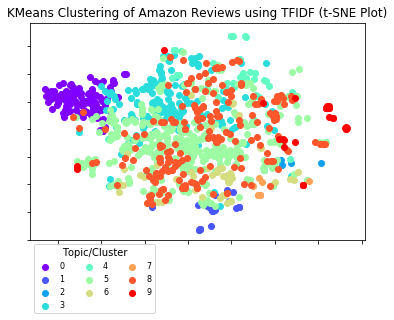

In [17]:
def plot_scatter_2d(x, y, c, sample_size, title):
    df = pd.DataFrame({'x': x, 'y': y, 'c': c}).sample(sample_size)
    l = len(np.unique(c))
    
    ax = plt.subplot(111)
    colors = cm.rainbow(np.linspace(0, 1, l))
                                   
    for c in range(0,l):
        qq = df[df['c']==c]
        ax.scatter(qq['x'], qq['y'],c=colors[c], label=c)
    plt.legend(loc='upper left', numpoints=1, ncol=3, fontsize=8, bbox_to_anchor=(0, 0), title='Topic/Cluster')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(title)
    plt.show()

%matplotlib inline
plot_scatter_2d(tsne_m[0], tsne_m[1], kmean_d, 1000, 'KMeans Clustering of Amazon Reviews using TFIDF (t-SNE Plot)')

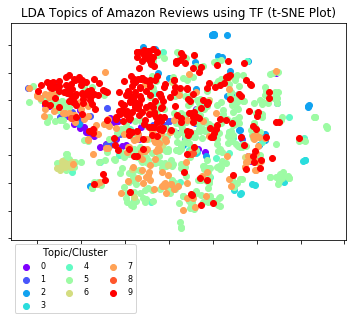

In [18]:
%matplotlib inline
plot_scatter_2d(tsne_m[0], tsne_m[1], lda_c, 1000, 'LDA Topics of Amazon Reviews using TF (t-SNE Plot)')

## Prepare data for rating prediction
The previous steps allowed us to understand how the data is structured, but it doesn't let us understand what drives positive or negative reviews. In the next steps, we look at the words within reviews to build a predictive scoring model. 

When training these types of models, overfitting can occur where we become very good at predicting our sample data, but fail to predict on new data. To avoid this, we split the data 70%/30% where we reserve the 30% for gauging our final accuracy.

We will build 3 models. One that predicts low, one that predicts high, and one that predicts neutral. For each review, we run it against all three models. The model that scores the highest will tell us which kind of review it likely is.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_d, source_data['rate_category'], test_size=0.3)

In [20]:
print(X_test, y_test)

  (0, 3857)	0.21147692000300233
  (0, 1553)	0.1979037768051097
  (0, 1227)	0.20808944668126417
  (0, 3860)	0.14886225527037525
  (0, 645)	0.2010071091109698
  (0, 3739)	0.16396136475095535
  (0, 475)	0.19716574515195806
  (0, 291)	0.20619219236925135
  (0, 1811)	0.4498382058850176
  (0, 1712)	0.2845235165901404
  (0, 3120)	0.35185907944261224
  (0, 2291)	0.09906631970320365
  (0, 61)	0.18549666820359142
  (0, 4103)	0.11415715727238537
  (0, 1457)	0.150770025032341
  (0, 3104)	0.2055801240457653
  (0, 761)	0.16295198022275048
  (0, 1723)	0.09380155875928137
  (0, 2338)	0.1970896858500072
  (0, 349)	0.12668495217349188
  (0, 1309)	0.12227811828306209
  (0, 383)	0.14287694376084892
  (0, 444)	0.21679430473354183
  (1, 3924)	0.08576792655783548
  (1, 4318)	0.09715351097007915
  :	:
  (2997, 2690)	0.2541389881593213
  (2997, 288)	0.2243240796501294
  (2997, 3785)	0.28139892067013905
  (2997, 748)	0.26169752290969023
  (2997, 2520)	0.2824056080659292
  (2997, 3156)	0.18839581384143206
  (299

## Calculate model accuracies
We try 3 different approaches to building the review predictions: Logistic Regression, Naive Bayes, and Support Vector Machines. We also try a final approach that does a combined "vote" of all three models. This means we are actually building (4 approaches) x (3 ratings) = 12 total models. Since we have limited data, we will use cross-validation to split the data 10 ways and measure accuracy in an unbiased way.

The accuracy % are printed below for each model.

In [21]:
cat = ['negative','neutral','positive']

def calculate_cv(X, y):
    results = {
        'lr': [],
        'svm': [],
        'nb': [],
        'combined': []
    }
    lm = LogisticRegression()
    svm = LinearSVC()
    nb = MultinomialNB()
    vc = VotingClassifier([('lm', lm), ('svm', svm), ('nb', nb)])
    
    for c in cat:
        y_adj = np.array(y==c)
        results['lr'].append((cross_val_score(lm, X, y_adj, cv=10, scoring='accuracy').mean(), c))
        results['svm'].append((cross_val_score(svm, X, y_adj, cv=10, scoring='accuracy').mean(), c))
        results['nb'].append((cross_val_score(nb, X, y_adj, cv=10, scoring='accuracy').mean(), c))
        results['combined'].append((cross_val_score(vc, X, y_adj, cv=10, scoring='accuracy').mean(), c))
    return results

cv_scores = calculate_cv(X_test, y_test)

print("Model accuracy predictions\n")
for m,s in cv_scores.items():
    for ss in s:
        print("{M} model ({R} rating): {S:.1%}".format(M=m.upper(), R=ss[1], S=ss[0]))
    print()

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocess

Model accuracy predictions

LR model (negative rating): 90.2%
LR model (neutral rating): 93.0%
LR model (positive rating): 84.2%

SVM model (negative rating): 91.1%
SVM model (neutral rating): 92.7%
SVM model (positive rating): 85.6%

NB model (negative rating): 90.2%
NB model (neutral rating): 93.0%
NB model (positive rating): 83.2%

COMBINED model (negative rating): 90.2%
COMBINED model (neutral rating): 93.0%
COMBINED model (positive rating): 84.2%



/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocess

## Training the model of choice
All models seem to have done roughly the same on low and neutral rating reviews. SVM seems to have given better performance for our 4-5 star reviews. There is definitely room for improvement. The distribution of the stratified raiting buckets were 33% each. 

If we guessed each review's status at random, that would be our % likelihood of guessing correct. Our three models show quite an improvement over random guessing, but still opportunity to improve. There are lots of ways to tweak the prior steps to get a better result. 
- We didn't tweak any parameters in either the TF step or the modeling step
- Neg/Pos keywords might vary by topic so we might do this for one cluster at a time
- Maybe nouns don't provide much insight and we are better off removing them
- "great" and "not great" have opposite meanings so maybe we should have included 2-grams

The list goes on, but I think you get the idea. The next steps just assume we are happy with our logistic regression model.

In [22]:
def get_lr(x, y):
    models = []
    for c in cat:
        y_adj = np.array(y==c)
        lm = LogisticRegression()
        lm_f = lm.fit(x, y_adj)
        models.append(lm_f)
    return models

lr_m = get_lr(X_train, y_train)

## Plot the results
The following three charts show the result of our Logistic Regression model. We show the top 12 words **negatively associated (red)** with that review model, and the top 12 words **positively associated (green)** with that review model. Roughly speaking, the values indiciate how much more likely or unlikely a review is to be low, neutral, high given the # of times that word occurs in the review.

In the first example, "review" has a very high likelihood of predicting a low review. Remember that words are stemmed so "easi" could refer to words like "easy, easier, easiest". We clearly see negative words associated with our negative model, and positive words with our positive model. Interestingly, the neutral reviews have words I'd consider as being unsure.


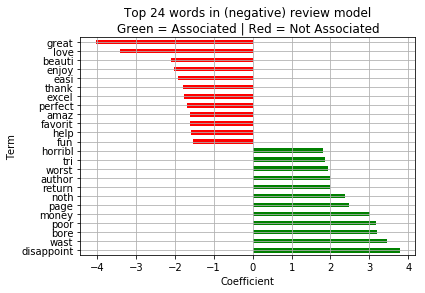

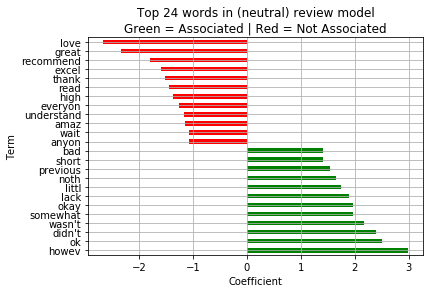

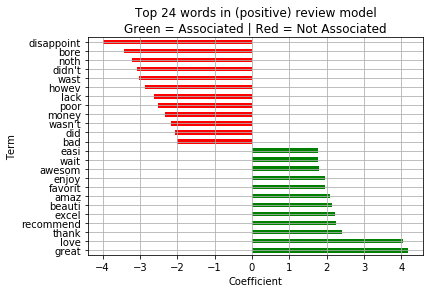

In [23]:
%matplotlib inline

def plot_coef(title, model, feature_names, n_words):
    v = []
    for topic_idx, topic in enumerate(model.coef_):
        [v.append([feature_names[i], model.coef_.item(i)]) for i in topic.argsort()[:-n_words - 1:-1]]
        [v.append([feature_names[i], model.coef_.item(i)]) for i in topic.argsort()[0:n_words]]
    df = pd.DataFrame(v, columns=['Term','Coefficient']).sort_values(by='Coefficient',ascending=False)
    df['c'] = df['Coefficient']>0
    ax = df.plot(x='Term', y='Coefficient', kind='barh', color=df['c'].map({True: 'g', False: 'r'}), grid=True, legend=False,
           title=title)
    ax.set_xlabel("Coefficient")

n_terms = 12
for c in range(0,len(cat)):
    plot_coef('Top {N} words in ({R}) review model\nGreen = Associated | Red = Not Associated'.format(N=n_terms*2, R=cat[c]), 
              lr_m[c], tfidf_m.get_feature_names(), n_terms)


## Test output
To put it altogether, below is a test function which allows you to supply your own review to see how well the model will predict it's rating. For simplicity, I stuck with the logistic regression model and only allow for one review at a time. 

The program uses the stored TFIDF matrix to tokenize and transform our new review which is then fed to all three of our logistic regression models. Each model has an independent assessment of how likely it is that our review is a positive hit. You could set some sort of threshold or take the model with the higest likelihood to make your determination.

In [24]:
def test_review(text):
    test_str = [text]
    test_new = tfidf_m.transform(test_str)

    print('Review text: "{R}"\n'.format(R=test_str[0]))
    print('Model Predction')
    for m in range(0,3):
        print('Model ({M}): {P:.1%}'.format(M=cat[m], P=lr_m[m].predict_proba(test_new)[0][1]))

In [25]:
test_review('They arrived damaged.')

Review text: "They arrived damaged."

Model Predction
Model (negative): 8.2%
Model (neutral): 5.0%
Model (positive): 87.4%


In [26]:
test_review('This is the best toaster oven I have ever owned! I am glad I bought it.')

Review text: "This is the best toaster oven I have ever owned! I am glad I bought it."

Model Predction
Model (negative): 3.1%
Model (neutral): 8.4%
Model (positive): 90.8%


# References

* Original Jupyter Notebook: https://github.com/zuenko/python/blob/4db739a658a550cfebbc4930002d925777f2edf4/yanix/Contest/ML_track/AmazonReview.ipynb